<a href="https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/RVE_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RVE for Remaining Useful Life Estimation (RUL)

This is a use case of a custom autoencoder model for a regression problem.

Check the original paper: <a href="https://www.sciencedirect.com/science/article/pii/S0951832022000321" target="_parent">Variational encoding approach for interpretable assessment of remaining useful life estimation</a> for more details.

In [1]:
# Install the library

!pip install rapidae

REMOVE

In [1]:
import os
import sys

notebook_dir = os.path.abspath('') # get the current notebook directory
sys.path.append(os.path.join(notebook_dir, '..', 'src')) # add src folder to path to import modules

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error
from rapidae.data import load_CMAPSS, CMAPSS_preprocessor
from rapidae.models import RVE
from rapidae.pipelines import PreprocessPipeline, TrainingPipeline
from rapidae.evaluate import evaluate, cmapps_score, plot_latent_space

2024-01-28 19:03:31.595408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 19:03:31.595453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 19:03:31.596135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 19:03:31.600300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 19:03:32.184108: W tensorflow/compiler/tf2

### Data

The data used is the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dataset, a popular benchmark in the field of predictive maintenance. The C-MAPSS dataset comprises four subsets with run-to-failure trajectories of aircraft engines and the task is to predict the RUL of an engine, which is a regression task. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type.

Fix some parameters:
 - The selected subset
 - The specific sensors
 - The length of the window
 - The smoothing instensity
 - The max RUL

For more information you can check the paper: https://www.sciencedirect.com/science/article/pii/S2665963822000537

In [3]:
subset = 'FD004'
# sensors to work with: T30, T50, P30, PS30, phi
sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12']
# windows length
sequence_length = 30
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125

The CMAPSS_preprocessor encapsulates a set of operations in order to prepare properly the data, like generating the RUL values, remove unused sensors, scaling, smoothing, etc.

In [4]:
data = load_CMAPSS(subset)

In [5]:


preprocess_pipeline = PreprocessPipeline(name='CMAPPS_preprocessing', 
                                         preprocessor=CMAPSS_preprocessor)

data = preprocess_pipeline(train=data["x_train"], 
                           test=data["x_test"], 
                           y_test=data["y_test"],
                           sensors=sensors, 
                           sequence_length=sequence_length, 
                           alpha=alpha, 
                           threshold=threshold)

2024-01-28 19:03:41 [INFO]: +++ CMAPPS_preprocessing +++
2024-01-28 19:03:41 [INFO]: Creating folder in ./output_dir/CMAPPS_preprocessing_2024-01-28_19-03-41
2024-01-28 19:03:41 [INFO]: Selected preprocessor is a function.


### Model

Fix hyperparameters for the model.

In [8]:
timesteps = data["x_train"].shape[1]
input_dim = data["x_train"].shape[2]
intermediate_dim = 300
batch_size = 128
latent_dim = 2

Create the model. Since we are working with a predefined model the original layers configuration are set by default.

In [9]:
model = RVE(input_dim=(timesteps, input_dim), 
            latent_dim=2,
            downstream_task='regression')

2024-01-28 14:04:11 [INFO]: Using default encoder
2024-01-28 14:04:12.005552: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-28 14:04:12.043779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-28 14:04:12.043840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-28 14:04:12.046259: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-28 14:04:1

### Training

Create and lauch the pipeline to train the model, in this example we have evaluation data so it can be fed as a dict to the pipeline.

In [35]:
epochs = 10000 # doesn't matter, we use early stopping
optimizer = 'adam'
pipeline = TrainingPipeline(name='RVE_RUL', 
                            model=model, 
                            num_epochs=epochs,
                            batch_size=batch_size,
                            optimizer='adam',
                            learning_rate=0.01
                            )

trained_model = pipeline(x=data["x_train"], y=data["y_train"], x_eval=data["x_val"], y_eval=data["y_val"])

2024-01-26 10:33:54 [INFO]: +++ RVE_RUL +++
2024-01-26 10:33:54 [INFO]: Creating folder in ./output_dir/RVE_RUL_2024-01-26_10-33-54


Epoch 1/10000

Epoch 1: val_loss improved from inf to 414.35165, saving model to ./output_dir/RVE_RUL_2024-01-26_10-33-54/model.weights.h5
341/341 - 91s - 267ms/step - kl_loss: 17.0729 - loss: 381.1149 - reg_loss: 364.0420 - val_kl_loss: 11.0662 - val_loss: 414.3517 - val_reg_loss: 403.2855
Epoch 2/10000

Epoch 2: val_loss improved from 414.35165 to 371.81607, saving model to ./output_dir/RVE_RUL_2024-01-26_10-33-54/model.weights.h5
341/341 - 89s - 260ms/step - kl_loss: 12.9588 - loss: 233.4725 - reg_loss: 220.5138 - val_kl_loss: 11.8432 - val_loss: 371.8161 - val_reg_loss: 359.9729
Epoch 3/10000

Epoch 3: val_loss improved from 371.81607 to 345.09534, saving model to ./output_dir/RVE_RUL_2024-01-26_10-33-54/model.weights.h5
341/341 - 88s - 257ms/step - kl_loss: 11.3857 - loss: 213.2979 - reg_loss: 201.9121 - val_kl_loss: 9.1902 - val_loss: 345.0953 - val_reg_loss: 335.9052
Epoch 4/10000

Epoch 4: val_loss improved from 345.09534 to 299.28891, saving model to ./output_dir/RVE_RUL_2024-

2024-01-26 11:08:04 [INFO]: Restoring best model
2024-01-26 11:08:04 [INFO]: Best model restored


### Evaluation step

Let's now make evaluate the model over the test set. The selected metrics to evaluate this are the mean square error and the CMAPSS score.
Here we can see the difference between using the evaluate method with a metric imported from the Scikit-Learn library and a custom one.

In [11]:
# borrar
model.load_weights("./output_dir/RVE_RUL_2024-01-26_10-33-54/model.weights.h5")

In [13]:
outputs = trained_model.predict(data["x_test"])

# model only predicts RULs lower than threshold
y_test = data["y_test"].clip(upper=threshold)

print("RMSE:", mean_squared_error(np.expand_dims(y_test, axis=-1), outputs['reg'], squared=False))
evaluate(y_true=np.expand_dims(y_test, axis=-1),
         y_hat=outputs['reg'], sel_metric=cmapps_score.CMAPSS_Score())

2024-01-28 14:06:00.100586: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step


2024-01-28 14:06:10 [INFO]: Using Rapidae custom metric...


RMSE: 88.93685053365137
test set results: [
	 CMAPSS_Score: 21563969.01492026 
]


array(21563969.01492026)

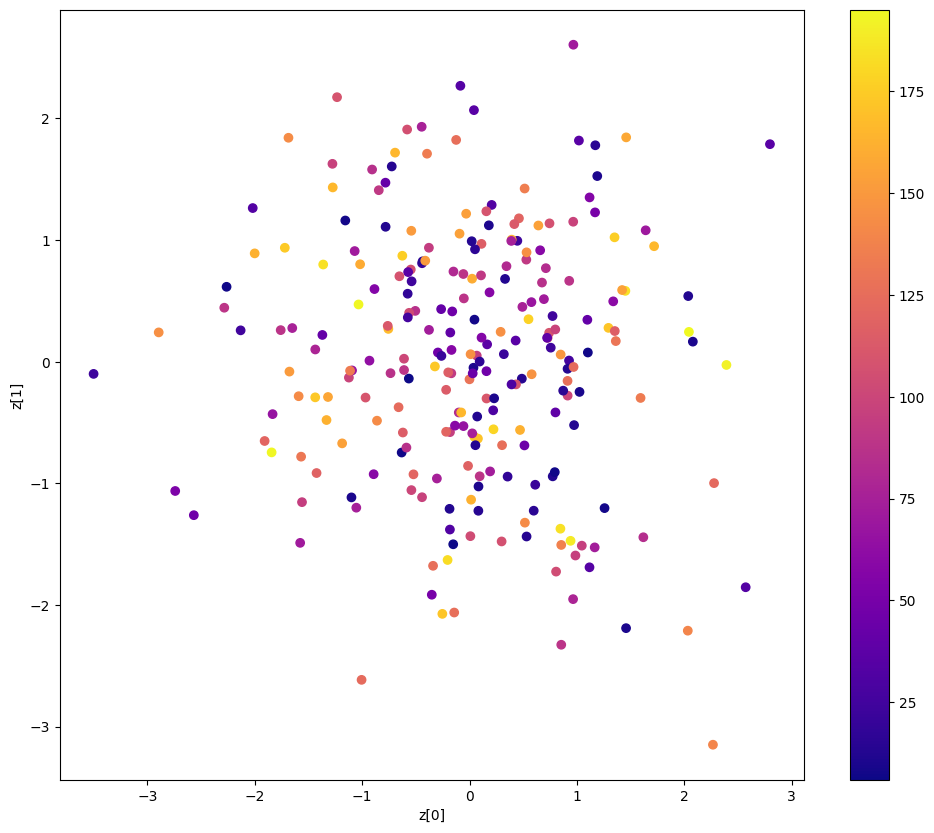

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

: 

In [14]:
plot_latent_space(outputs['z'], data["y_test"])

In [ ]:
# save outputs['z'] and data["y_test"] to disk
dict_to_save = {'z': outputs['z'], 'y_test': data["y_test"]}
np.savez_compressed('./output_dir/RVE_RUL_2024-01-26_10-33-54/latent_space.npz', **dict_to_save)

# open latent space
latent_space = np.load('./output_dir/RVE_RUL_2024-01-26_10-33-54/latent_space.npz')

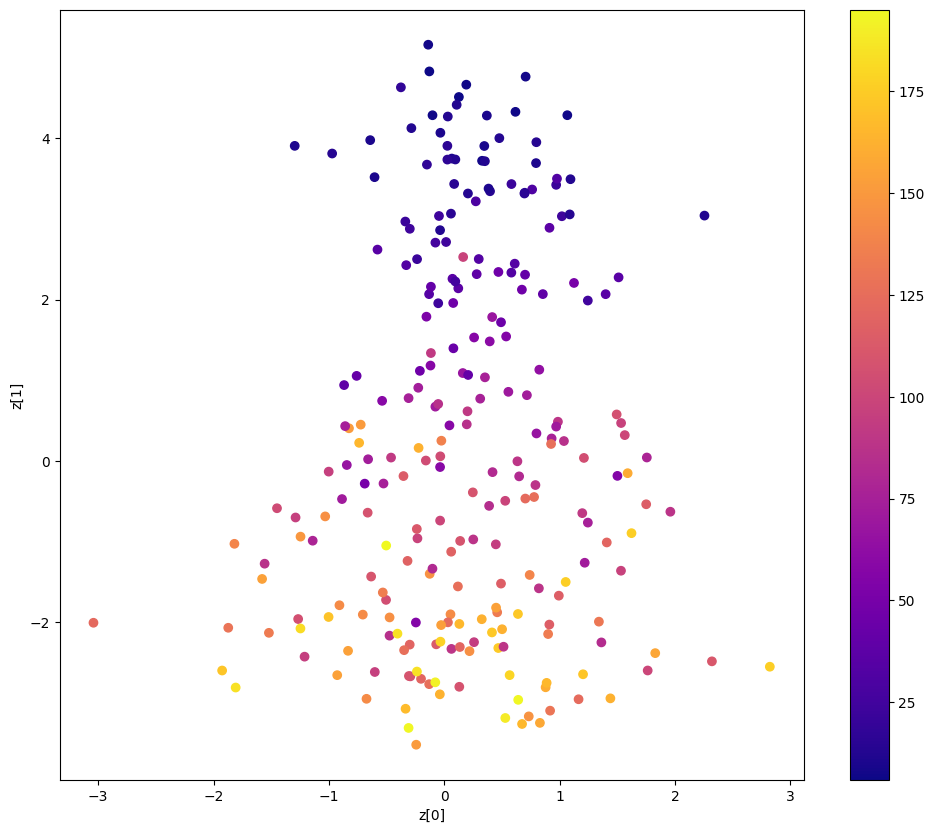

<Figure size 640x480 with 0 Axes>

In [41]:
latent = plot_latent_space(outputs['z'], data["y_test"])

In [47]:
# get data from latent space
latent = np.array(latent)

In [49]:
latent

array(<Figure size 640x480 with 1 Axes>, dtype=object)

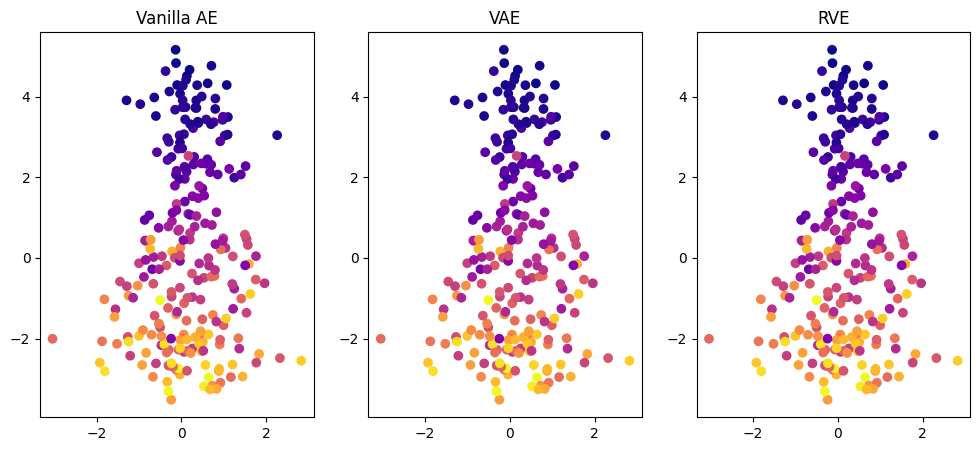

In [61]:
# create a figure in matplotlib with 3 subplots

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# fill it with random data
axs[0].scatter(outputs["z"][:, 0], outputs["z"][:, 1], c=data['y_test'], cmap="plasma")
axs[0].set_title('Vanilla AE')
axs[1].scatter(outputs["z"][:, 0], outputs["z"][:, 1], c=data['y_test'], cmap="plasma")
axs[1].set_title('VAE')
axs[2].scatter(outputs["z"][:, 0], outputs["z"][:, 1], c=data['y_test'], cmap="plasma")
axs[2].set_title('RVE')

# set the title of the figure
#fig.suptitle('Latent space projections')
plt.show()

In [62]:
# save fig in max resolution
fig.savefig('latent_space.png', dpi=300)

# AE

In [6]:
from rapidae.models import AE
from rapidae.models.base import RecurrentEncoder, RecurrentDecoder

In [7]:
timesteps = data["x_train"].shape[1]
input_dim = data["x_train"].shape[2]
intermediate_dim = 300
batch_size = 128
latent_dim = 2

In [31]:
from rapidae.models import BaseAE, BaseRegressor
from keras import ops, losses


# --------------- 2. CUSTOM MODEL --------------
class CustomModel(BaseAE):
    def __init__(self,input_dim, latent_dim, encoder, decoder):
        BaseAE.__init__(
            self,
            input_dim,
            latent_dim,
            encoder=encoder,
            decoder=decoder,
        )
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.regressor = BaseRegressor()
        
    def call(self, x):
        # IMPLEMENT FORWARD PASS
        z = self.encoder(x)
        reg_prediction = self.regressor(z)
        output = self.decoder(z)
        outputs = {}
        outputs["z"] = z
        outputs["reg"] = reg_prediction
        outputs["dec"] = output

        return outputs
      
    def compute_loss(self, 
                     x=None, 
                     y=None, 
                     y_pred=None, 
                     sample_weight=None):
        # IMPLEMENT LOSS FUNCTION
        reg_loss = ops.mean(losses.mean_squared_error(y, y_pred["reg"]))
        rec_loss = ops.mean(losses.mean_squared_error(x, y_pred["dec"]))
        loss = reg_loss + rec_loss

        return loss

In [32]:
model = CustomModel(input_dim=(timesteps,input_dim), 
            latent_dim=2,
            encoder=RecurrentEncoder,
            decoder=RecurrentDecoder)

In [34]:
epochs = 10000 # doesn't matter, we use early stopping
optimizer = 'adam'
pipeline = TrainingPipeline(name='AE_RUL', 
                            model=model, 
                            num_epochs=epochs,
                            batch_size=batch_size,
                            optimizer='adam',
                            learning_rate=0.01
                            )

trained_model = pipeline(x=data["x_train"], y=data["y_train"], x_eval=data["x_val"], y_eval=data["y_val"])

2024-01-28 19:21:09 [INFO]: +++ AE_RUL +++
2024-01-28 19:21:09 [INFO]: Creating folder in ./output_dir/AE_RUL_2024-01-28_19-21-09


Epoch 1/10000


2024-01-28 19:21:09.702781: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31336560 exceeds 10% of free system memory.
2024-01-28 19:21:09.725734: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31336560 exceeds 10% of free system memory.
2024-01-28 19:21:10.423750: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


: 